In [296]:
import numpy as np                                     # Matlab like syntax for linear algebra and functions
import matplotlib.pyplot as plt                        # Plots and figures like you know them from Matlab
import seaborn as sns                                  # Make the plots nicer to look at
from iminuit import Minuit                             # The actual fitting tool, better than scipy's
import sys             
from sympy import *                                # Module to see files and folders in directories
from scipy import stats
from scipy.stats import binom
from scipy.special import binom as binomcoef
from scipy.special import expit
import pandas as pd
import os
from importlib import reload

sys.path.append('../External_Functions')
import ExternalFunctions
reload(ExternalFunctions)
from ExternalFunctions import UnbinnedLH, BinnedLH, Chi2Regression
from ExternalFunctions import nice_string_output, add_text_to_ax, add_header_to_ax

sys.path.append('../Extra_External_Functions')
import EEF
reload(EEF)
from EEF import Datahandler

In [124]:
# Usefull functions
def acceptreject(func, xmin, xmax, ymin, ymax, N_points):
    # Recursive function to do accept/reject monte carlo simulation
    xran = np.random.uniform(xmin, xmax, N_points)
    yran = np.random.uniform(ymin, ymax, N_points)
    yfunc = func(xran)
    xkeep = xran[yran < yfunc]
    missing = N_points - len(xkeep)
    if missing > 0:
        xrest, tries = acceptreject(func, xmin, xmax, ymin, ymax, missing)
    else:
        xrest = np.array([])
        tries = 0
    finalx = np.append(xkeep, xrest)
    finaltries = N_points + tries
    return finalx, finaltries

def acceptrejectdata(func, xmin, xmax, ymin, ymax, N_points):
    x, tries = acceptreject(func, xmin, xmax, ymin, ymax, N_points)
    eff = N_points/tries
    area = (xmax - xmin) * (ymax - ymin) * eff
    return x, tries, area, eff

def F_dis(dataset1, dataset2):
    var1 = np.var(dataset1, ddof = 1)
    var2 = np.var(dataset2, ddof = 1)
    if var1 > var2:
        F = var1/var2
    else:
        F = var2/var1
    print(F)
    return F

def student_t(dataset1, dataset2):
    mean1 = np.mean(dataset1)
    var1 = np.var(dataset1, ddof = 1) #Estimated var
    N1 = len(dataset1)
    mean2 = np.mean(dataset2)
    var2 = np.var(dataset2, ddof = 1) #Estimated var
    N2 = len(dataset2)
    S = np.sqrt(((N1-1)*var1 + (N2-1)*var2)/(N1+N2-2))
    t = (mean1 - mean2)/(S * np.sqrt(1/N1 + 1/N2))
    print(t)
    return t

def geterrors(z, symlist, vals, sigmas):    
    def variances(func, symbols, values, sigmas):
        variance = np.zeros(len(symbols))
        for idx, (symbol, sigma) in enumerate(zip(symbols,sigmas)):
            f = lambdify(symbols, func.diff(symbol)**2 * sigma **2)
            variance[idx] = f(*values)
        return variance
    Vz = variances(z, symlist, vals, sigmas)
    print(Vz)
    sigmaz = np.sqrt(np.sum(Vz))
    zvalue = lambdify(symlist, z)(*vals)
    
    return zvalue, sigmaz

def geterrors_corr(z, symlist, vals, sigmas, corrmatrix):    
    def variances(func, symbols, values, sigmas, corrmatrix):
        # Makes a variance matrix which can we summed and sqrt'ed to find the uncertainty
        # ***Need to be rework to it make more general for more correlations*** 
        # ***Would also be nice to not have a nested loop***
        variance = np.zeros((len(symbols), len(symbols)))
        for idx, (isymbol, isigma) in enumerate(zip(symbols,sigmas)):
            for jdx, (jsymbol, jsigma) in enumerate(zip(symbols,sigmas)):
                
                f = lambdify(symbols, func.diff(isymbol) * func.diff(jsymbol) * isigma * jsigma * corrmatrix[idx, jdx])
                variance[idx, jdx] = f(*values)
        
        return variance
    Vz = variances(z, symlist, vals, sigmas, corrmatrix)
    print(Vz)
    sigmaz = np.sqrt(np.sum(Vz.flatten()))
    zvalue = lambdify(symlist, z)(*vals)
    
    return zvalue, sigmaz 

def basicinfo(data):
    entries = len(data)
    mean = np.mean(data)
    std = np.std(data, ddof = 1)
    eom = std/np.sqrt(entries)
    print(f"Data has {entries:d} entries with the mean = {mean:.3f} +/- {eom:.3f} and std = {std:.3f}")
    return entries, mean, std, eom

def chi2test_onesample(expY, y, sy):
    return np.sum((y - expY)**2/sy**2)

def gensum(pdf, xmin, xmax, ymin, ymax, rn, runs):
    results = np.zeros(runs)
    for i in range(runs):
        xvalues, _ = acceptreject(pdf, xmin, xmax, ymin, ymax, rn)
        results[i] = np.sum(xvalues)
    return results

def weighted_mean(data, error):
    return np.sum((data / error**2)/np.sum(1 / error**2))

def weighted_std(error):
    return np.sqrt(1 / np.sum(1 / error**2))

## Problem 1
#### (1.1)

0.1746663219402081
1.8257418583505538
0.09519541280308985
[[1.         0.60257785]
 [0.60257785 1.        ]]
0.17664


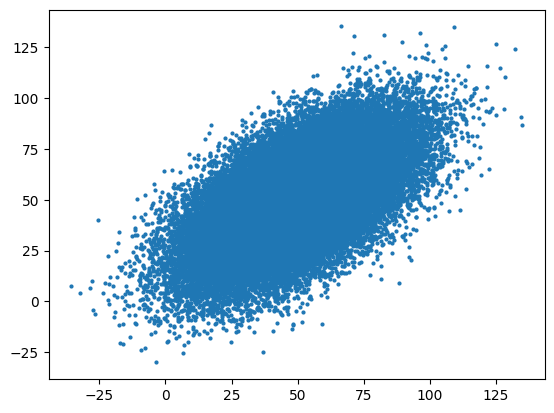

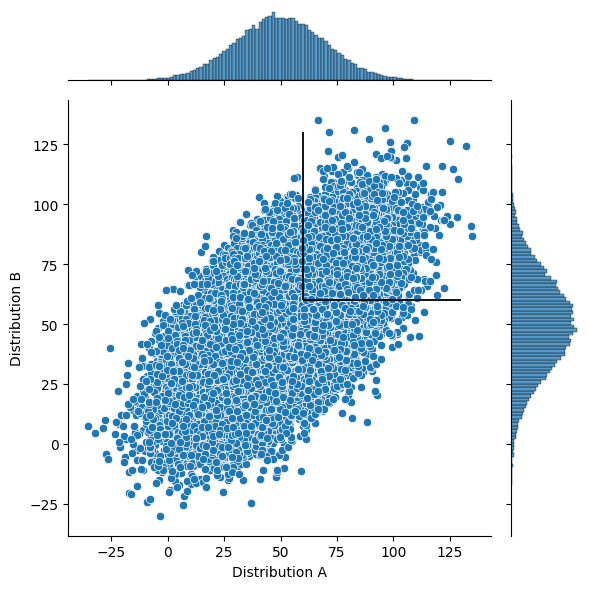

In [343]:
# The scores of two tests (A & B) are both Gaussianly distributed with μ = 50, σ = 20.
# Part 1. What fraction of students will get a score in test A in the range [55,65]?
# This can be solved using the sf function to 55 - 65
mu = 50
sigma = 20
prob1 = stats.norm.sf(55, mu, sigma) - stats.norm.sf(65, mu, sigma)
print(prob1) # p = 0.17

# Part 2. What uncertainty on the mean score do you obtain from 120 B test scores?
# As the sigma is known and the distributions are gaussian the error on the mean will be sigma/sqrt(N)
eom = sigma/np.sqrt(120)
print(eom) # eom = 1.8

# Part 3. If scores correlate with ρA,B = 0.60, what fraction should get a score above 60 in both tests?
# WIP
prob2 = stats.norm.sf(60, mu, sigma) * stats.norm.sf(60, mu, sigma)
print(prob2)
means = [50, 50]
cov = [
    [20**2, 0.6*20*20],
    [0.6*20*20, 20**2]    
]
N_points = 50000
x,y = np.random.default_rng().multivariate_normal(means, cov, N_points).T
print(np.corrcoef(x,y))
plt.scatter(x, y, s = 4)
print(np.sum(np.logical_and(x > 60, y > 60))/N_points)
plt.show()
# fig, ax = plt.subplots(1,1, figsize = (6,6))
sns.jointplot(x = x, y = y, marker = "o", palette = ["blue"], edgecolors = ["blue"])
plt.xlabel("Distribution A")
plt.ylabel("Distribution B")
plt.hlines(60, 60, 130, color = "k", linewidth = 1.3)
plt.vlines(60, 60, 130, color = "k", linewidth = 1.3)
plt.tight_layout()
plt.savefig("correlatedscores", dpi = 400)
plt.show()

In [332]:
means = [50, 50]
cov = [
    [20**2, 0.6*20*20],
    [0.6*20*20, 20**2]    
]
N_points = 50000
ps = np.zeros(100)
for i in range(100):
    x,y = np.random.default_rng().multivariate_normal(means, cov, N_points).T
    # print(np.corrcoef(x,y))
    # plt.scatter(x, y, s = 4)
    p = np.sum(np.logical_and(x > 60, y > 60))/N_points
    ps[i] = p
basicinfo(ps)


Data has 100 entries with the mean = 0.180 +/- 0.000 and std = 0.002


(100, 0.17981619999999998, 0.001787407569129609, 0.0001787407569129609)

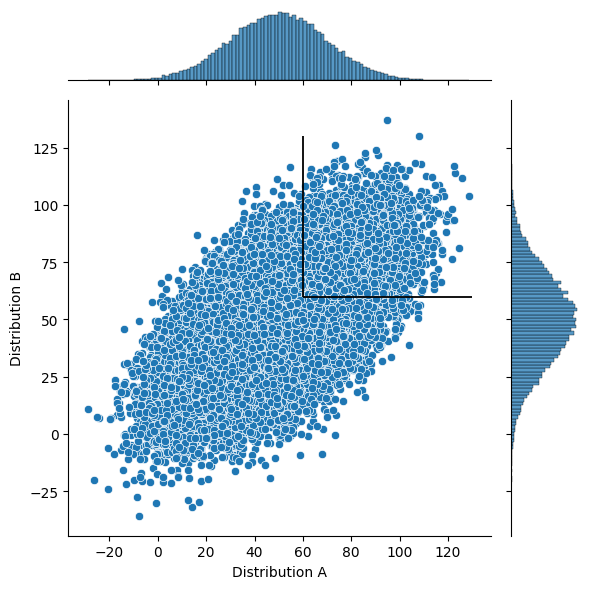

In [341]:
sns.jointplot(x = x, y = y, marker = "o", palette = ["blue"], edgecolors = ["blue"])
plt.xlabel("Distribution A")
plt.ylabel("Distribution B")
plt.tight_layout()
plt.savefig("correlatedscores", dpi = 400)
plt.hlines(60, 60, 130, color = "k", linewidth = 1.3)
plt.vlines(60, 60, 130, color = "k", linewidth = 1.3)
plt.show()

#### (1.2)

0.12752124614721688


<BarContainer object of 21 artists>

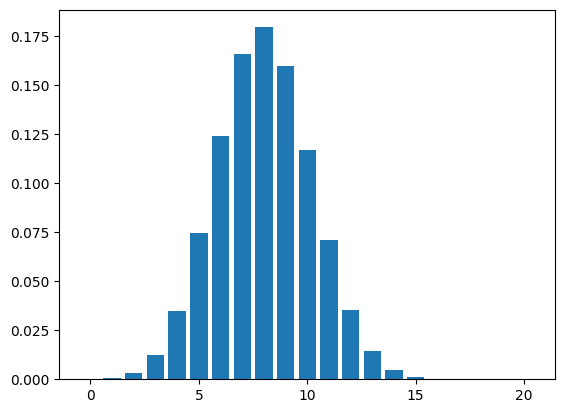

In [346]:
# A game is designed such that on average 40% of persons will win it.

# Part 1. If 20 random persons play the game, what is the chance that 11 or more will win it?
# A binomial distribution
p = 0.4
N = 20
r = 11
prob2 = stats.binom.sf(r-1, N, p)
print(prob2) # p = 0.13
rlin = np.arange(0, 21, 1)
plin = stats.binom.pmf(rlin, N, p)
plt.bar(rlin, plin)

## Problem 2
#### (2.1)

In [347]:
# Let x = 1.033 ±0.014 and y = 0.07 ±0.23, and let z1 = xye^−y and z2 = (y+ 1)^3/(x−1)
xv = 1.033
xerr = 0.014
yv = 0.07
yerr = 0.23
x, y = symbols("x y")

z1 = x * y * exp(-y)
zv, zerr = geterrors(z1, (x,y), (xv, yv), (xerr, yerr))
print(zv, zerr)
# The variance i get is Vz = Vz(x) + Vz(y) = Vz = 8.34931649e-07 + 4.24444573e-02.
# Clearly y contributes more
corrmatrix = np.array([
    [1, 0.4],
    [0.4, 1]
])
z2 = (y+1)**3/(x-1)

z1v, z1err = geterrors_corr(z1, (x,y), (xv, yv), (xerr, yerr), corrmatrix)
print(z1v, z1err) # z1 = 0.07 +/- 0.2
z2v, z2err = geterrors_corr(z2, (x,y), (xv, yv), (xerr, yerr), corrmatrix)
print(z2v, z2err) # z2 = 40 +/- 20

# Part 3. What is the Pearson correlation between z1 and z2 for z1 ∈[−1,1] and z2 ∈[−1,1]? Ill genereate 2000 points in this range
# WIP

[8.34931649e-07 4.24444573e-02]
0.06742139711739911 0.20602255265570826
[[8.34931649e-07 7.53001681e-05]
 [7.53001681e-05 4.24444573e-02]]
0.06742139711739911 0.20638772380872863
[[ 248.0292945  -150.80446023]
 [-150.80446023  573.06701594]]
37.122515151515245 22.792266012270947


#### (2.2)

In [32]:
# In a (Cavendish) experiment, you have made five measurements of Earth’s density ρ:
results = np.array([5.50, 5.61, 4.88, 5.07, 5.26])
results_err = np.array([0.10, 0.21, 0.15, 0.14, 0.13])

# Part 1. What is the combined result and uncertainty of these five measurements?

r = weighted_mean(results, results_err)
r_err = weighted_std(results_err)
print(r, r_err) # with weighted mean and std rho = 5.28 +/- 0.06

def twosampleknownsigma(mean1, sigma1, mean2, sigma2):
    dif = np.abs(mean1 - mean2)
    sigma = np.sqrt(sigma1**2 + sigma2**2) # assuming no correlation
    sigmasfrom0 = dif/sigma
    # two tailed
    # print(sigmasfrom0)
    return 2 * stats.norm.cdf(-sigmasfrom0, 0, 1)

pvalues = []
for idx, (mean1, sigma1) in enumerate(zip(results, results_err)):
    for jdx, (mean2, sigma2) in enumerate(zip(results, results_err)):
        if jdx > idx:
            # print(mean1, mean2)
            p = twosampleknownsigma(mean1, sigma1, mean2, sigma2)
            pvalues.append(p)
print(pvalues)
pvalues2 = []
for p in pvalues:
    pvalues2.append(stats.binom.sf(0,10,p))
print(pvalues2)
# given a 5% significance level
pvalues2 = np.array(pvalues2)
# I see that two pairs of measurements are still in consistantant with eachother
# it is 1 with 3 and 2 with 3
# The uncertainty on 3 is lower than 2 but 1 is lower than 3, 
# and there are two measurements with disagrees with 3 therefore I choose to remove it.
results = np.array([5.50, 5.61, 5.07, 5.26])
results_err = np.array([0.10, 0.21, 0.14, 0.13])
# Then i get
r = weighted_mean(results, results_err)
r_err = weighted_std(results_err)
print(r, r_err) # rho = 5.36 +/- 0.07

# Part 3
# ill measure the amount of sigmas away
# the null is that they are the same value with a 5% significance
truev = 5.514
sigmaaway = np.abs((r - truev)/r_err)
print(sigmaaway) # 2.4184642832633303 sigma away
# this is a two tailed test
p = 2 * stats.norm.sf(2.42, 0, 1)
print(p) #p = 0.02
#The measured quantity is not consistant with the real value.




5.279305828390055 0.06005034708204228
[0.636265305181146, 0.0005835627387778286, 0.012443040766606805, 0.14338371427172408, 0.00467385767994753, 0.03239051203104419, 0.15645118504198452, 0.3544442446165508, 0.0555674896649096, 0.31997685200883286]
[0.9999594634035092, 0.0058203266648449966, 0.11768931668116936, 0.7872530864938421, 0.04576770661445966, 0.2805490635943228, 0.8175675055083513, 0.987429933541025, 0.4354410659256216, 0.9788535746567701]
5.355516150592899 0.06553077938916381
2.4184642832633303
0.015520507101107285


#### (2.3)

In [37]:
# An ellipse E has semi-major axis a = 1.04 ±0.27 and eccentricity e = 0.71 ±0.12.

# Part 1. The area A of an ellipse is generally A = πa2√1 −e2. What is the area of the ellipse E?
a, e = symbols("a e")
av = 1.04
aerr = 0.27
ev = 0.71
eerr = 0.12
area_func = np.pi * a**2 * sqrt(1 - e**2)

area, areaerr =  geterrors(area_func, (a, e), (av, ev), (aerr, eerr))
print(area, areaerr) # A = 2.4 +/- 1.3

cirmin_func = 4 * a * sqrt(2-e**2)
cirmin, cirminerr =  geterrors(cirmin_func, (a, e), (av, ev), (aerr, eerr))
print(cirmin, cirminerr)

cirmax_func = np.pi * a * sqrt(4-2 * e**2)
cirmax, cirmaxerr =  geterrors(cirmax_func, (a, e), (av, ev), (aerr, eerr))
print(cirmax, cirmaxerr)

# Then I take a weighted mean and weighted error to estimate the circumference
cir = weighted_mean(np.array([cirmin, cirmax]), np.array([cirminerr, cirmaxerr]))
cirerr = weighted_std(np.array([cirminerr, cirmaxerr]))
print(cir, cirerr) # C = 5.3 +/- 1.0

[1.54364721 0.16901225]
2.3928396994627668 1.3086861574841329
[1.74481776 0.08397757]
5.087970817526375 1.3523295926287366
[2.15258263 0.10360317]
5.651314683758895 1.502060518464218
5.340172871287868 1.0050205807174966


## Problem 3
#### (3.1)

1.0
0.15865525393145707
233
[0.1714 0.1552 0.1632 0.1584 0.1518]


C:\Users\Philip\AppData\Local\Temp\ipykernel_3552\3283990304.py:77: UserWarning: Legend does not support handles for list instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#controlling-the-legend-entries
  ax.legend(handles = [hands, hands2], labels = [labs, labs2], frameon = False, fontsize = 12)


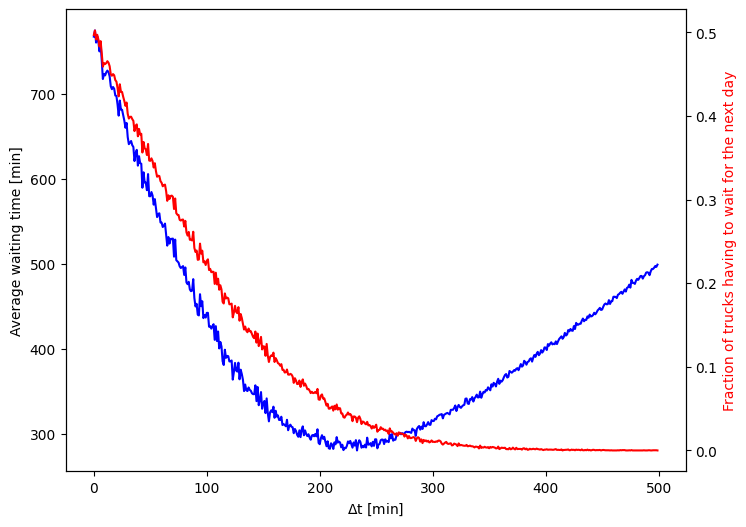

In [321]:
# You are optimising container transport, in particular the time, ∆t, between the daily truck arrivals (120 minutes uncertainty) and the ship departure (50 minutes uncertainty)

# Part 1. If ∆t = 130 minutes, what fraction of containers will have to wait to the next day?

# The two events are assumed to be gaussian distributed

# truck data
tmu = 0
tsigma = 120

# ship data
smu = 130
ssigma = 50

# xlin = np.linspace(tmu - 3* tsigma, smu + 3 * tsigma, 1000)
# ty = stats.norm.pdf(xlin, tmu, tsigma)
# sy = stats.norm.pdf(xlin, smu, ssigma)
# plt.plot(xlin, ty)
# plt.plot(xlin, sy)
# plt.show()


def twosampleknownsigma(mean1, sigma1, mean2, sigma2):
    dif = np.abs(mean1 - mean2)
    sigma = np.sqrt(sigma1**2 + sigma2**2) # assuming no correlation
    sigmasfrom0 = dif/sigma
    # xlin = np.linspace(dif - 3 * sigma, dif + 3 * sigma, 1000)
    # y = stats.norm.pdf(xlin, dif, sigma)
    # plt.plot(xlin, y)
    # one tailed
    print(sigmasfrom0)
    return stats.norm.cdf(-sigmasfrom0, 0, 1)

p = twosampleknownsigma(tmu, tsigma, smu, ssigma)
print(p) # On average 0.16 will miss the ship.
# Do sim to check

# Part 2. For what value of ∆t do containers, on average, have the least waiting time?
N_points = 5000
dtvalues = np.arange(0, 500, 1)
results = np.zeros_like(dtvalues, dtype = np.float64)
fracs = np.zeros_like(dtvalues, dtype = np.float64)
for idx, dt in enumerate(dtvalues):
    smu = dt
    xmin = -tsigma * 3
    xmax = dt + tsigma * 4
    ymin = 0
    t_ymax = stats.norm.pdf(0, 0, tsigma)
    s_ymax = stats.norm.pdf(0, 0, ssigma)
    def gauss_pdf_t(x):
        return stats.norm.pdf(x, tmu, tsigma)
    def gauss_pdf_s(x):
        return stats.norm.pdf(x, smu, ssigma)
    tvalues, _, tarea, _ = acceptrejectdata(gauss_pdf_t, xmin, xmax, ymin, t_ymax, N_points)
    svalues, _, sarea, _ = acceptrejectdata(gauss_pdf_s, xmin, xmax, ymin, s_ymax, N_points)
    # plt.hist(tvalues)
    mask = svalues > tvalues
    arrive_before_wait = svalues[mask] - tvalues[mask]
    arrive_after_wait = np.array([24*60 for i in tvalues[~mask]])
    # print(np.mean(np.append(arrive_before_wait, arrive_after_wait)))
    results[idx] = np.mean(np.append(arrive_before_wait, arrive_after_wait))
    hmm = (~mask).sum()/N_points
    fracs[idx] = hmm
minarg = np.argmin(results)
print(dtvalues[minarg])
print(fracs[128:133])
res = Datahandler((dtvalues, results, np.zeros_like(results)), binneddata=False)
res.initplot(figsize = (8,6))
res.quickplot(errorplot=False, xlabel = r"$\Delta$t [min]", ylabel = "Average waiting time [min]", label = "Simulated average waiting time")
ax = res.ax
ax2 = ax.twinx()
ax2.plot(dtvalues, fracs, color = "r", label = "Fraction of trucks having to wait for the next day")
ax2.set_ylabel("Fraction of trucks having to wait for the next day", color = "r")
fig = res.fig
hands, labs = ax.get_legend_handles_labels()
hands2, labs2 = ax2.get_legend_handles_labels()
ax.legend(handles = [hands, hands2], labels = [labs, labs2], frameon = False, fontsize = 12)

# best value around dt = 220 with a fraction of 5% which stays 

233
[0.1714 0.1552 0.1632 0.1584 0.1518]
[<matplotlib.lines.Line2D object at 0x00000190BBBD7BD0>, <matplotlib.lines.Line2D object at 0x00000190BBBCCF10>]


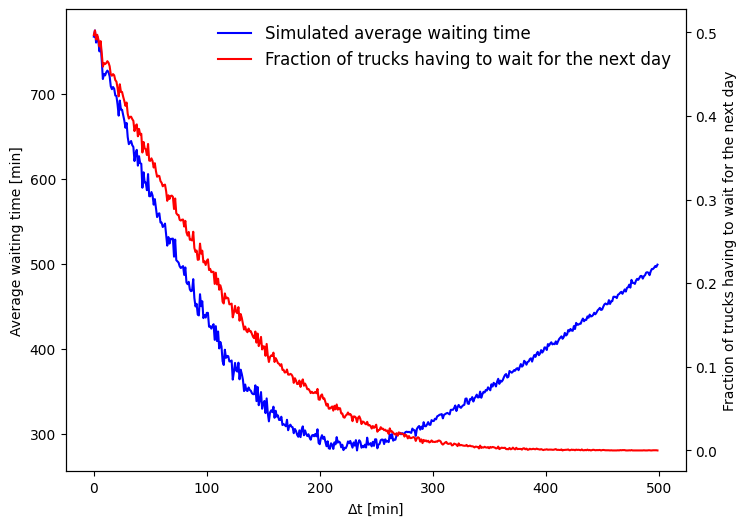

In [329]:
minarg = np.argmin(results)
print(dtvalues[minarg])
print(fracs[128:133])
res = Datahandler((dtvalues, results, np.zeros_like(results)), binneddata=False)
res.initplot(figsize = (8,6))
res.quickplot(errorplot=False, xlabel = r"$\Delta$t [min]", ylabel = "Average waiting time [min]", label = "Simulated average waiting time")
ax = res.ax
ax2 = ax.twinx()
ax2.plot(dtvalues, fracs, color = "r", label = "Fraction of trucks having to wait for the next day")
ax2.set_ylabel("Fraction of trucks having to wait for the next day")
fig = res.fig
hands, labs = ax.get_legend_handles_labels()
hands2, labs2 = ax2.get_legend_handles_labels()
hands.append(hands2[0])
labs.append(labs2[0])
print(hands)
ax.legend(handles = hands, labels = labs, frameon = False, fontsize = 12)

#### (3.2)

0.33317307955182246
1.0405155513798328


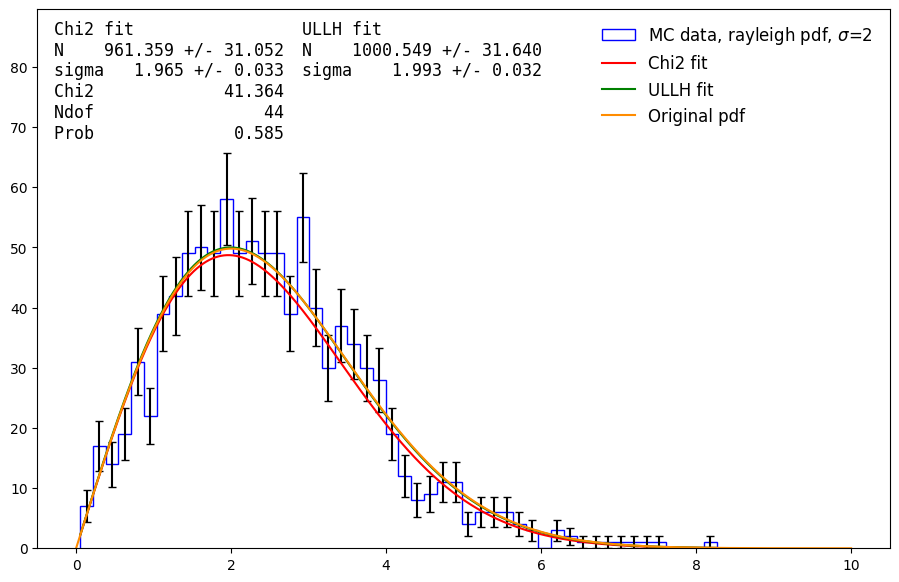

In [307]:
# The Rayleigh distribution is a PDF given by: f(x) = xσ2exp(−12x2/σ2), with x ∈[0,∞]. 
# 
# 
# Part 1. By what method(s) would you generate random numbers (from uniform) according to f(x)?
# This distribution it would be best to use the inversion method as it could take the whole range of x values into account
# Still. that method is more comperesome and I will just do accept/reject from 0 to 5*sigma

# Part 2. Generate N=1000 random numbers according to f(x) for σ = 2, and plot these
N = 1000
sigma = 2
def rayleigh(x):
    return stats.rayleigh.pdf(x, 0, sigma)
xmin = 0
xmax = 5 * sigma
ymin = 0
ymax = stats.rayleigh.pdf(sigma * np.sqrt(2 * np.log(2)), sigma)
print(ymax)

xpoints, _, area, _ = acceptrejectdata(rayleigh, xmin, xmax, ymin, ymax, N)
print(area)

bins = 50
data = Datahandler(xpoints, bins)
data.initplot(figsize = (11,7))
data.quickplot(label = r"MC data, rayleigh pdf, $\sigma$=2 ")

# Part 3. Fit this distribution of random numbers. How well can you determine σ from the fit?

binwidth = data.binwidth
def rayleighfit(x, N, sigma):
    return N * binwidth * stats.rayleigh.pdf(x, 0, sigma)
data.chi2fit(rayleighfit, N = 1000, sigma = 2)
data.plotfit()
def rayleighfit2(x, N, sigma):
    return N * stats.rayleigh.pdf(x, 0, sigma)
data.ullhfit(rayleighfit2, extended = True, N = 1000, sigma = 1.9)
data.plotfit(topspace = 0, textboxspace = 0.29)
ax = data.ax
xlin = np.linspace(xmin, xmax, 1000)
ax.plot(xlin, rayleighfit(xlin, 1000, 2), label = "Original pdf", color = "darkorange")
data.ax = ax
data.legend()

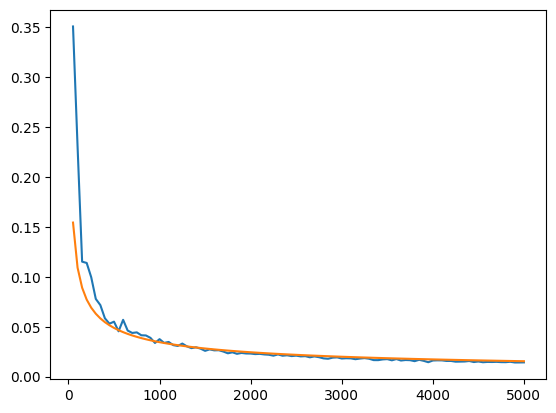

In [155]:
# Part 4
# I did both chi2 and ullh for the one sample, but will just do chi2 for the many samples

Nvalues = np.linspace(50, 5000, 100)
sigma = 2
xmin = 0
xmax = 5 * sigma
ymin = 0
ymax = stats.rayleigh.pdf(sigma * np.sqrt(2 * np.log(2)), sigma)



bins = 50
sigmasigmas = np.zeros_like(Nvalues)
for idx, N in enumerate(Nvalues):
    xpoints, _, area, _ = acceptrejectdata(rayleigh, xmin, xmax, ymin, ymax, int(N))
    data = Datahandler(xpoints, bins)
    binwidth = data.binwidth
    def rayleighfit(x, N, sigma):
        return N * binwidth * stats.rayleigh.pdf(x, 0, sigma)
    _, sigmasigma = data.chi2fit(rayleighfit, N = 1000, sigma = 2)
    sigmasigmas[idx] = sigmasigma[1]
plt.plot(Nvalues, sigmasigmas)
std = np.mean(sigmasigmas*np.sqrt(Nvalues))
def oneoversqrtN(x):
    return std/np.sqrt(x)
plt.plot(Nvalues, oneoversqrtN(Nvalues))
# it looks like the two graphs follow each other well as soon as enough numbers are generated. 

## Problem 4
#### (4.1)

,PatientID,Temp,BloodP,Age,Status (0: Healthy; 1: Ill; -1: Unknown)
0,1.0,36.3,125.7,56.8,0.0
1,2.0,37.6,121.4,67.7,1.0
2,3.0,38.7,117.6,67.3,1.0
3,4.0,35.8,116.3,60.0,0.0
4,5.0,37.6,142.9,81.9,0.0
...,...,...,...,...,...
995,996.0,37.1,127.6,74.2,-1.0
996,997.0,36.9,123.7,47.1,-1.0
997,998.0,37.3,113.4,39.2,-1.0
998,999.0,37.0,129.3,68.3,-1.0


400 400 200


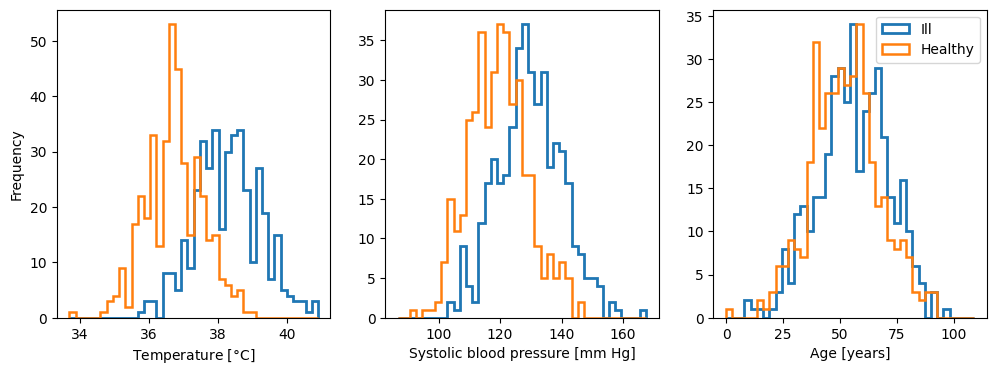

KstestResult(statistic=0.1325, pvalue=0.0017621899205092087)


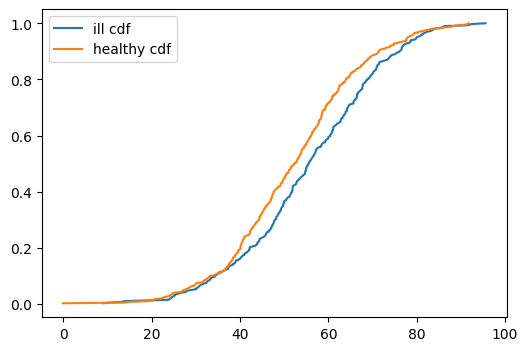

In [180]:
# Patients are either healthy or infected with Anoroc disease and their temperature, 
# blood pressure and age is found in www.nbi.dk/∼petersen/data AnorocDisease.csv. 
# For patients 1-800 (control) the outcome in known, while it is unknown for patients 801-1000 (unknown).

# Part 1. Using the control sample, plot the three distributions for healthy and sick, respectively. 
# Which of the three single measures gives the highest separation between healthy and sick?

dataframe = pd.read_csv("data_AnorocDisease.csv")
display(dataframe)
pid, temp, bloodp, age, status = dataframe.to_numpy().T

illmask = status == 1.0
healthymask = status == 0.0
unknownmask = status == -1.0
print(illmask.sum(), healthymask.sum(), unknownmask.sum())

fig, axes = plt.subplots(1, 3, figsize = (12,4))
ax1, ax2, ax3 = axes
bins = 40
temprange = (min(temp), max(temp))
ax1.hist(temp[illmask], bins = bins, histtype="step", label = "Ill", range = temprange, linewidth = 2)
ax1.hist(temp[healthymask], bins = bins, histtype="step", label = "Healthy", range = temprange, linewidth = 1.8)
ax1.set_ylabel("Frequency")
ax1.set_xlabel(r"Temperature [$\degree$C]")

bloodprange = (min(bloodp), max(bloodp))
ax2.hist(bloodp[illmask], bins = bins, histtype="step", label = "Ill", range = bloodprange, linewidth = 2)
ax2.hist(bloodp[healthymask], bins = bins, histtype="step", label = "Healthy", range = bloodprange, linewidth = 1.8)
ax2.set_xlabel(r"Systolic blood pressure [mm Hg]")

agerange = (min(age), max(age))
ax3.hist(age[illmask], bins = bins, histtype="step", label = "Ill", range = agerange, linewidth = 2)
ax3.hist(age[healthymask], bins = bins, histtype="step", label = "Healthy", range = agerange, linewidth = 1.8)
ax3.set_xlabel(r"Age [years]")

ax3.legend()
plt.show()
# Looks like temperature is the best seperated variable
# Part 2. Test if the age distribution is statistically the same between healthy and sick.
# I set up a two-sample Kolmogorov-Smirnov test to test if the distributions are the same.
# The null is that they are the same and i give it a 5% significance level.
kstest = stats.ks_2samp(age[healthymask], age[illmask])
print(kstest) # p = 0.002 this is below our threshold and the null hypothesis must be rejected.

fig, ax = plt.subplots(1, 1, figsize = (6,4))
ax.plot(sorted(age[illmask]), np.cumsum([1 for i in age[illmask]])/len(age[illmask]), label = "ill cdf")
ax.plot(sorted(age[healthymask]), np.cumsum([1 for i in age[healthymask]])/len(age[illmask]), label = "healthy cdf")
ax.legend()
# from the plot it is difficult to see, but plotting the cdfs it is clear they are not the same.

# Part 3. Given any combination of all three variables, separate the two groups as well as possible and estimate the number of infected patients in the unknown group.
# Do a fisher determinant

# Part 4. Assuming a prior probability of p = 0.01 of being ill, what is the probability that a new patient with T = 38.6 C◦is ill?
# Do some baysian statistics

#### (4.2)

,Country,GDP,PopSize,Happiness-index,EconomicFreedom-index,PressFreedom-index,Education-index
0,Afghanistan,592.0,18356000.0,2523.0,53.0,40.19,0.414
1,Albania,5837.0,2187000.0,5117.0,65.2,30.59,0.746
2,Algeria,3638.0,27620000.0,4887.0,49.7,47.26,0.672
3,Argentina,9929.0,30799000.0,5929.0,52.7,28.99,0.855
4,Armenia,4595.0,2176000.0,5283.0,71.9,28.83,0.740
...,...,...,...,...,...,...,...
128,Uruguay,16965.0,2530000.0,6431.0,69.3,16.38,0.765
129,Venezuela,1627.0,18359000.0,4892.0,24.7,47.60,0.700
130,Vietnam,3743.0,68565000.0,5411.0,61.7,78.46,0.630
131,Zambia,1115.0,8331000.0,4073.0,50.4,38.21,0.557


mean =  17362.045112781954
median =  6677.0
25% quantiles =  2047.0
75% quantiles =  23762.0


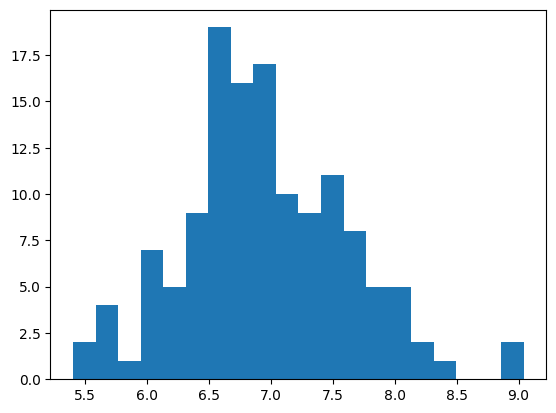

PearsonRResult(statistic=0.7647440306793953, pvalue=8.917365454350595e-27)
[[1.         0.76474403]
 [0.76474403 1.        ]]
SpearmanrResult(correlation=0.8043593869327467, pvalue=2.0653149674359925e-31)


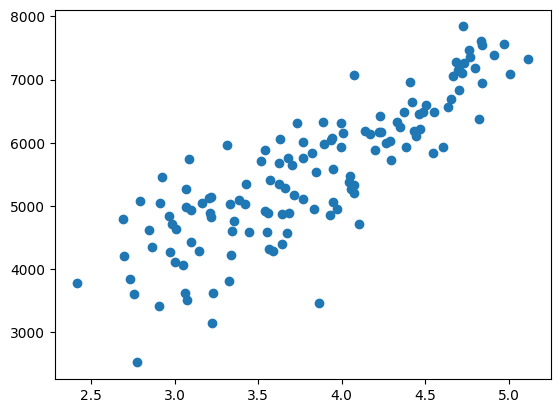

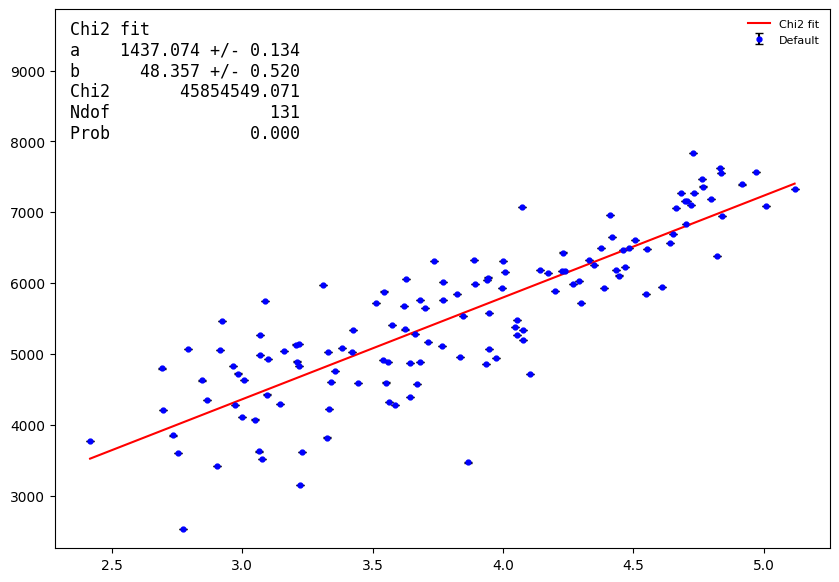

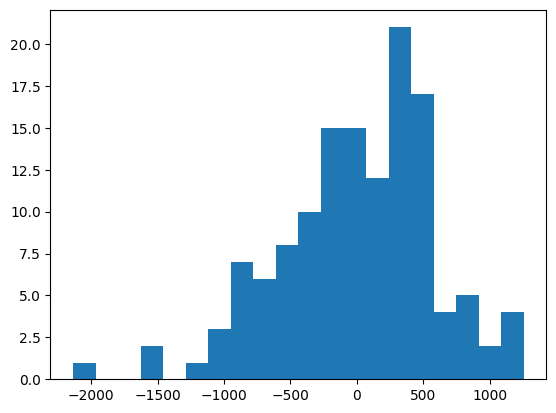

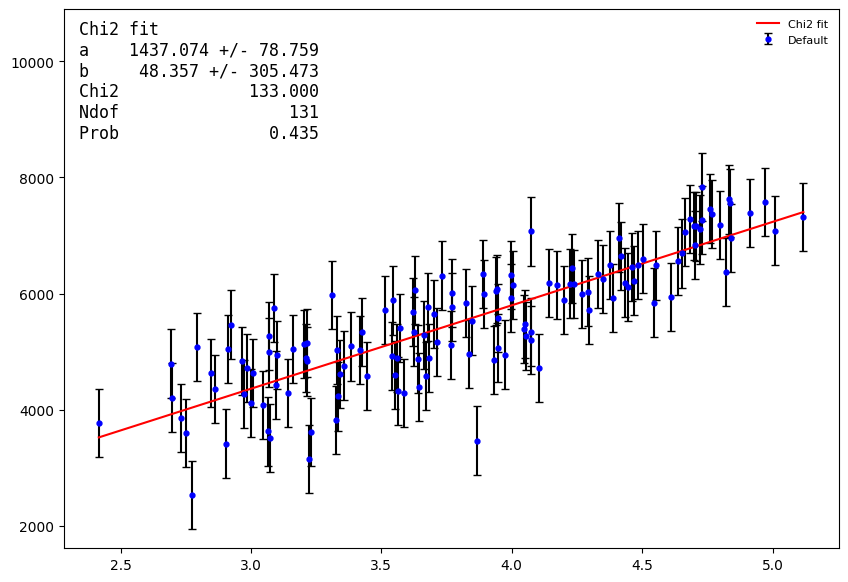

587.1720749912308


In [240]:
# The file www.nbi.dk/∼petersen/data CountryScores.csv 
# contains a list of countries along with several key numbers and indices.
dataframe = pd.read_csv("data_CountryScores.csv")
country, gdp, pop, happ, ecof, press, edu = dataframe.to_numpy().T
display(dataframe)
# Part 1. Determine the mean, median, 25%, and 75% quantiles of the GDP.
print("mean = ", np.mean(gdp)) # mean = 17362
print("median = ", np.median(gdp)) # median = 6677
print("25% quantiles = ", np.quantile(gdp, 0.25)) # 25% quantiles = 2047
print("75% quantiles = ", np.quantile(gdp, 0.75)) # 75% quantiles = 23762

# Part 2. Does the distribution of log10(PopSize) follow a Gaussian distribution?
# print(pop)
poplog = np.log10(list(pop))
plt.hist(poplog, 20)
plt.show()
# set a 5% significance level for the anderson darling test for normality
ad_stats = stats.anderson(poplog)
# print(ad_stats)
# The log10(pop) is normal within a 5% significance level

# Part 3. What are the Pearson and Spearman correlations between happiness and education indeces?
rho_pearson1 = stats.pearsonr(happ, edu)
rho_pearson2 = np.corrcoef(list(happ), list(edu))
rho_spear = stats.spearmanr(happ, edu)
print(rho_pearson1)
print(rho_pearson2)
print(rho_spear)
# with the null hypothesis that they are not correlated, one can also calculate the p value for this correlation. if we again give it a significance level of 5%
# I see that the p values are much lower than the set significance and therefore the null is rejected.

# Part 4. 
plt.scatter(np.log10(list(gdp)), list(happ))
# So from this I see a somewhat linear relationship between happiness and log(gdp)
# theory is that happ = a * log(gdp) + b
# first I just set the error equal to 1
data = Datahandler([np.log10(list(gdp)), list(happ), np.ones_like(gdp)], binneddata= False)
data.initplot()
data.quickplot(lineplot = False)
def fitfunc(x, a, b):
    return a * x + b
fitv, fiterr = data.chi2fit(fitfunc, a = 2000, b = -2000)
data.plotfit()
data.legend()
plt.show()
# Errors are to low so will estimate them by way of residual distribution
res = np.array(happ) - fitfunc(np.log10(list(gdp)), *fitv)
plt.hist(res, 20)
plt.show()
estimated_error = np.std(res)

data = Datahandler([np.log10(list(gdp)), list(happ), [estimated_error for i in happ]], binneddata= False)
data.initplot()
data.quickplot(lineplot = False)
def fitfunc(x, a, b):
    return a * x + b
fitv, fiterr = data.chi2fit(fitfunc, a = 2000, b = -2000)
data.plotfit()
data.legend()
plt.show()
print(error) # The estimated error is 600 under the hypothesis that the relation is linear

## Problem 5
#### (5.1)

,Area,sigArea,Volume,sigVolume
0,2.44922,0.02758,0.10127,0.01091
1,2.48328,0.03630,0.10776,0.00834
2,1.54516,0.02648,0.04989,0.00349
3,2.45672,0.03140,0.06795,0.00104
4,1.45687,0.02270,0.03490,0.00312
...,...,...,...,...
429,2.08141,0.02792,0.10545,0.00791
430,1.76906,0.02897,0.05093,0.00681
431,1.59750,0.02184,0.06665,0.00568
432,1.95797,0.03534,0.06338,0.00384


0.013281048830950434 0.10065155981461331


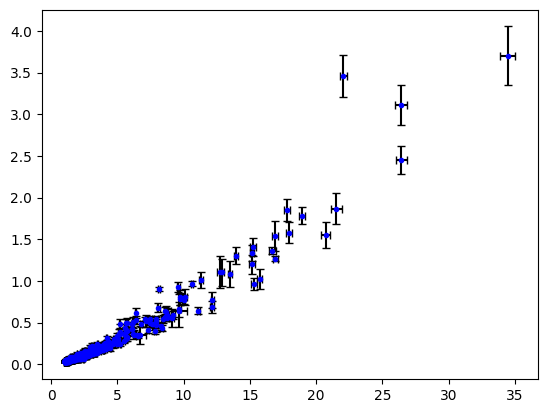

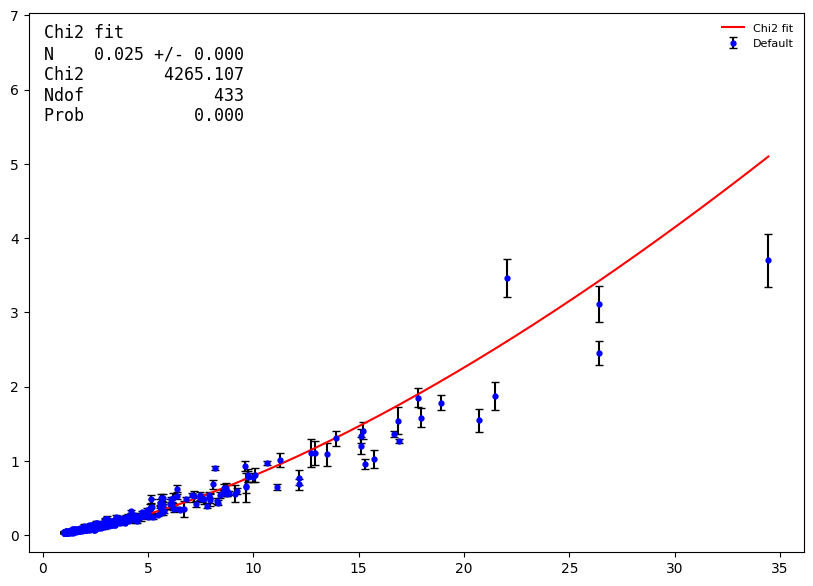

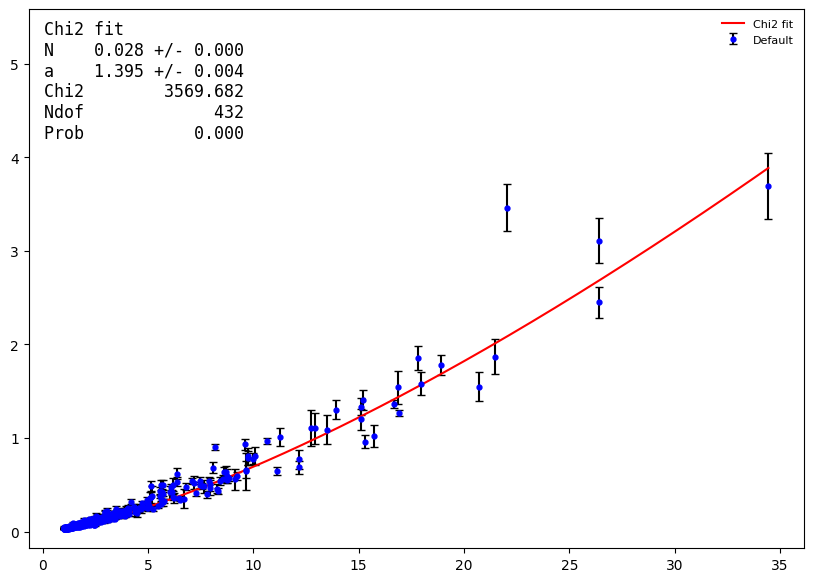

In [249]:
# The file www.nbi.dk/∼petersen/data GlacierSizes.csv contains the estimated area 
# and volume including uncertainties of 434 glaciers with an area above 1 km

dataframe = pd.read_csv("data_GlacierSizes.csv")
area, sigarea, volume, sigvolume = dataframe.to_numpy(dtype=np.float64).T
display(dataframe)
plt.errorbar(area, volume, xerr = sigarea, yerr = sigvolume, capsize = 3, fmt = ".", ecolor = "k", color = "b")
print(np.mean(sigarea/area), np.mean(sigvolume/volume)) # the mean reletive error on the volume is 10x that of the area
# The reletive erro on the volume is 0.10, and 0.013 on the area.

# Therefore, we can ignore the area uncertainties as they negligible.
data = Datahandler([area, volume, sigvolume], binneddata=False)
data.initplot()
data.quickplot(lineplot = False)
def fit_func(x, N):
    return N * x**(3/2)
data.chi2fit(fit_func, N = 1)
data.plotfit()
data.legend()
plt.show()
# Part 3.
# The fit does not match the data
# It seems like the volume is growing slower than A**(3/2) but maybe it is that the data clustering is misrepresenting the larger areas

# Part 4
data = Datahandler([area, volume, sigvolume], binneddata=False)
data.initplot()
data.quickplot(lineplot = False)
def fit_func(x, N, a):
    return N * x**(a)
data.chi2fit(fit_func, N = 1, a = 3/2)
data.plotfit()
data.legend()